In [1]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import pandas as pd
import geopandas as gpd
from IPython.display import IFrame
%matplotlib inline

# turn response caching on and turn on logging to your terminal window
ox.config(log_console=True, use_cache=True)

ox.__version__

'1.0.0'

# Get network with OSMnx

OSMnx lets you download street network data and build topologically-corrected street networks, project and plot the networks, and save the street network as SVGs, GraphML files, GeoPackages, or shapefiles for later use. The street networks are directed and preserve one-way directionality.

You can download a street network by providing OSMnx any of the following:
  - a bounding box
  - a lat-long point plus a distance
  - an address plus a distance
  - a place name or list of place names (to automatically geocode and get the boundary of)
  - a polygon of the desired street network's boundaries
  - a .osm formatted xml file
  
You can also specify several different network types:
  - 'drive' - get drivable public streets (but not service roads)
  - 'drive_service' - get drivable streets, including service roads
  - 'walk' - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
  - 'bike' - get all streets and paths that cyclists can use
  - 'all' - download all non-private OSM streets and paths (this is the default network type unless you specify a different one)
  - 'all_private' - download all OSM streets and paths, including private-access ones

In the following, we define a function to download the graph for the city of Mérida, Yucatán, or, if already present, load it as an NetworkX graph object.

In [67]:
places = [{'county' : 'Merida',
           'state' : 'Yucatan',
           'country' : 'Mexico'},
          {'county' : 'Kanasin',
           'state' : 'Yucatan',
           'country' : 'Mexico'}]

def get_roads_osmnx(places, update=False, proj=False, crs=None):

    dirpath = pathlib.Path('./networks/')
    filepath = dirpath/'merida-kanasin-road.graphml'
    logpath = dirpath/'log'
                                    
    if filepath.exists() and not update:
        G = ox.load_graphml(filepath)
    else:
        # get drivable public streets network, aka road network, without service roads,
        # e.g. private, parking lots, etc.
        # use retain_all if you want to keep all disconnected subgraphs (e.g. when your places aren't adjacent)
        # TODO: It would be nice to setup up a polygon for the city and its surrounding areas, to be sure
        # exactly the location.
        G = ox.graph_from_place(places, network_type='drive')
        ox.save_graphml(G, filepath=filepath, gephi=False)
        
    if proj:
        G = ox.project_graph(G, to_crs=crs)
    
    print(f"Graph created at: {G.graph['created_date']}")
    return G, *ox.graph_to_gdfs(G)
        
G, nodes, edges = get_roads_osmnx(places, update=False)
G_proj, nodes_proj, edges_proj = get_roads_osmnx(places, update=False, proj=True, crs=3857)

Graph created at: 2021-02-17 11:36:16
Graph created at: 2021-02-17 11:57:58


The Coordinate Reference System (CRS) is important because the geometric shapes in a GeoDataFrame object are simply a collection of coordinates in an arbitrary space. A CRS tells Python how those coordinates relate to places on the Earth. (Reference: https://geopandas.org/projections.html)

It is more convenient to work with a flattened 2D projection rather than its spherical coordinates. Usually this happens where we are interested in some region such as one city. The standard convention for such projected maps is to take $x =$ Easting and $y =$ Northing, in the order $(x, y)$, in meters from some origin. It is not possible to make a perfect flat version of an ellipsoid surface, so any projection must make some compromise. Usually a good projection to use is one of the Universal Transverse Mercator (UTM) family. UTM splits the Earth’s
surface into state-sized regions, and defines separate projection for each one, to minimize the distortion
there. (Retrieved from: https://link.springer.com/chapter/10.1007/978-3-319-72953-4_5)

The same CRS can often be referred to in many ways. For example, one of the most commonly used CRS is the WGS84 latitude-longitude projection. This can be referred to using the authority code "EPSG:4326". However, such EPSG is in degree units. For that reason, we will use an alternative option which is the "EPSG:3857" that is measured in meters. This projected coordinate system is the one that Google, OpenStreetMap, Bing, ArcGIS, ESRI, etc. use for rendering their maps. (See: https://epsg.io/3857)

In [70]:
G_proj.graph

{'created_date': '2021-02-17 11:57:58',
 'created_with': 'OSMnx 1.0.0',
 'crs': <Projected CRS: EPSG:3857>
 Name: WGS 84 / Pseudo-Mercator
 Axis Info [cartesian]:
 - X[east]: Easting (metre)
 - Y[north]: Northing (metre)
 Area of Use:
 - name: World between 85.06°S and 85.06°N.
 - bounds: (-180.0, -85.06, 180.0, 85.06)
 Coordinate Operation:
 - name: Popular Visualisation Pseudo-Mercator
 - method: Popular Visualisation Pseudo Mercator
 Datum: World Geodetic System 1984
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 'simplified': True}

In the following, we can see the difference when query the city of Merida and the county of Merida. We can see that it is different the way that OSM works with these two definitions.

The first plot we query the city of Merida. The second plot is the county that takes into account the other sub municipalities that conform the Merida Municipality.

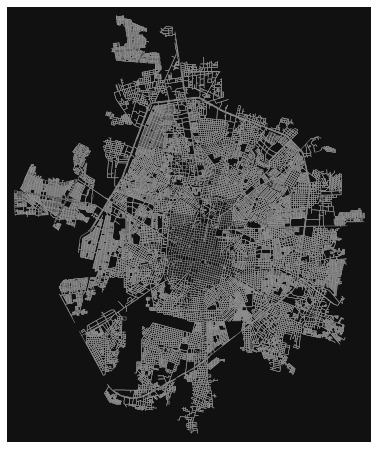

In [4]:
places_city = [{'city' : 'Merida',
             'state' : 'Yucatan',
             'country' : 'Mexico'},
             {'city' : 'Kanasin',
             'state' : 'Yucatan',
             'country' : 'Mexico'}]

city = ox.graph_from_place(places_city, 
                           network_type='drive',
                           #retain_all=True
                          )
fig, ax = ox.plot_graph(city, 
                        #bgcolor='k', 
                        node_size=0, 
                        #node_color='#999999', 
                        #node_edgecolor='none', 
                        #node_zorder=2,
                        #edge_color='#555555', 
                        edge_linewidth=0.5, 
                        #edge_alpha=1, 
                        #figsize=(50,50)
                       )
plt.close()

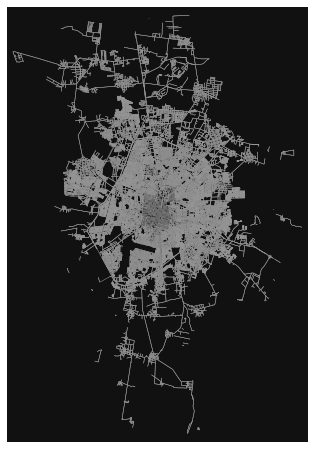

In [35]:
places_county = [{'county' : 'Merida',
             'state' : 'Yucatan',
             'country' : 'Mexico'},
             {'county' : 'Kanasin',
             'state' : 'Yucatan',
             'country' : 'Mexico'}]

county = ox.graph_from_place(places_county, 
                           network_type='drive',
                           retain_all=True
                          )
fig, ax = ox.plot_graph(county, 
                        #bgcolor='k', 
                        node_size=0, 
                        #node_color='#999999', 
                        #node_edgecolor='none', 
                        #node_zorder=2,
                        #edge_color='#555555', 
                        edge_linewidth=0.5, 
                        #edge_alpha=1, 
                        #figsize=(50,50)
                       )
plt.close()

In the following plot, we set a polygon of the Merida Municipality and its surroundings to know where exactly is located.

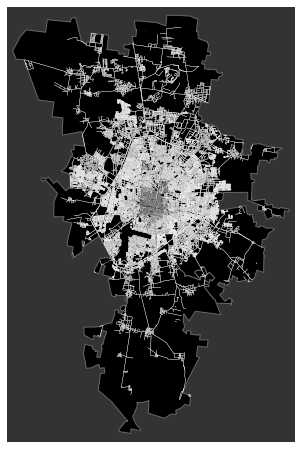

In [19]:
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon

gdf = ox.geocode_to_gdf(places_county)

fig, ax = ox.plot_graph(county, show=False, close=False, bgcolor='#333333',
                        edge_color='w', edge_linewidth=0.3, node_size=0)
# to this matplotlib axis, add the place shape as descartes polygon patches
for geometry in gdf['geometry'].tolist():
    if isinstance(geometry, (Polygon, MultiPolygon)):
        if isinstance(geometry, Polygon):
            geometry = MultiPolygon([geometry])
        for polygon in geometry:
            patch = PolygonPatch(polygon, fc='k', ec='#666666', lw=1, alpha=1, zorder=-1)
            ax.add_patch(patch)

# optionally set up the axes extents
margin = 0.02
west, south, east, north = gdf.unary_union.bounds
margin_ns = (north - south) * margin
margin_ew = (east - west) * margin
ax.set_ylim((south - margin_ns, north + margin_ns))
ax.set_xlim((west - margin_ew, east + margin_ew))
plt.show()

TODO: Discuss the graph objects, nodes and edges, and what attributes do they posses. Print an example of each.

# Some general consideration on the data structures, graph and dataframes

In [81]:
type(G_proj)

networkx.classes.multidigraph.MultiDiGraph

In [82]:
print(f"The road network has {G_proj.number_of_edges()} edges and {G_proj.number_of_nodes()} nodes")

The road network has 102400 edges and 37906 nodes


Nodes are street intersections, with y and x coordinates and the number of streets intersecting the node, and other potential attributes.

Nodes are indexed by an integer value.

In [83]:
G_proj.nodes[287026838]

{'y': 2393289.4596048235,
 'x': -9975735.711525183,
 'street_count': 3,
 'lon': -89.6135586,
 'lat': 21.0118318}

We now list all attributes present in the graph nodes:

In [84]:
from itertools import chain

set(chain.from_iterable(d.keys() for *_, d in G_proj.nodes(data=True)))

{'highway', 'lat', 'lon', 'street_count', 'x', 'y'}

We have a highway attribute, how many nodes have this attribute?

In [85]:
h_count = 0
for node, attr in G_proj.nodes.items():
    if 'highway' in attr.keys():
        h_count += 1
h_count

888

What are its possible values?

In [86]:
set(nx.get_node_attributes(G_proj, 'highway').values())

{'crossing',
 'mini_roundabout',
 'passing_place',
 'traffic_signals',
 'turning_circle',
 'turning_loop'}

Edges are roads and are indexed by their starting and ending nodes, and a zero(TODO; what is that zero?). They are tuple objects.

OK, the zero is the edge key, since in a multigraph we can have potentially more than one edge between a pair of nodes, each edge is identofied by a key.

TODO: Determine is this is indeed a multigraph. Are more than one edge for any pair of nodes? Use the key.

In [87]:
for u in G_proj.nodes():
    for neighbor in G_proj.neighbors(u):
        if G_proj.number_of_edges(u, neighbor) > 2:
            print (u,neighbor)

2028847780 2028847782
2028847782 2028847780


In [88]:
G_proj.edges[2028847780, 2028847782, 0]

{'osmid': 443843678,
 'oneway': False,
 'highway': 'residential',
 'length': 53.545,
 'geometry': <shapely.geometry.linestring.LineString at 0x7fc9df3dea30>,
 'name': 'Calle 32'}

In [89]:
G_proj.edges[2028847782, 2028847780, 1]

{'osmid': [369316954, 369316955, 369316951],
 'oneway': False,
 'highway': 'residential',
 'length': 188.21699999999998,
 'geometry': <shapely.geometry.linestring.LineString at 0x7fc9df3de910>,
 'name': ['Calle 30', 'Calle 39-A', 'Calle 39B-1']}

We now list all available attributes.

In [90]:
set(chain.from_iterable(d.keys() for *_, d in G_proj.edges(data=True)))

{'access',
 'bridge',
 'geometry',
 'highway',
 'junction',
 'lanes',
 'length',
 'maxspeed',
 'name',
 'oneway',
 'osmid',
 'ref',
 'tunnel',
 'width'}

TODO: Explore what are each of these, their possible values and units, the projection in case of the geometry, and how many nodes posses each attribute (or fraction of total nodes) to give an idea of how useful they are.

TODO: Visualize tha graph with all attributes either printed or as an overlay.



Folium is too slow, and the html is too large (100 megs), maybe there are some tricks to increase performance. And we haven't even added the nodes.

Let's try some static maps from osmnx directly, and using geopandas.


# Basic Network Stats



omsnx already provides quite an array of useful metrics that can be automatically calculated.


In [91]:
## what sized area does our network cover in square meters?
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m # Squared meters? What is the oficial value?

1154181781.7111275

According to the INEGI, as of 2020, the continental surface of Merida is 874.4 squared kilometers. (Follow Medio Ambiente > Superficie continental,2020: https://www.inegi.org.mx/app/indicadores/?ag=31050#divFV1001000001)

In [92]:
%%time
basic_stats = ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')
basic_stats.keys()

CPU times: user 1min 15s, sys: 1.31 s, total: 1min 17s
Wall time: 1min 17s


dict_keys(['n', 'm', 'k_avg', 'intersection_count', 'streets_per_node_avg', 'streets_per_node_counts', 'streets_per_node_proportion', 'edge_length_total', 'edge_length_avg', 'street_length_total', 'street_length_avg', 'street_segments_count', 'node_density_km', 'intersection_density_km', 'edge_density_km', 'street_density_km', 'circuity_avg', 'self_loop_proportion', 'clean_intersection_count', 'clean_intersection_density_km'])

# Importing data from Marco Geoestadístico - Censo de Poblacion y Vivienda 2020 (https://www.inegi.org.mx/app/biblioteca/ficha.html?upc=889463807469)

In order to perform some analysis involving how data metrics change with scale, we import the AGEB (Areas Geoestadísticas Básicas Urbanas) of the city from the Marco Geoestadístico and Censo 2020 to create a subgraph for each different AGEB.

From the data from the Marco Geoestadistico we are only using the geometries because it does not contain information from Censo 2020.

Geometries we can use:

<ul>
    <li>Areas geoestadísticas básicas urbanas (AGEB). Filename: ee<strong>a</strong></li>
    <li>Polígonos de manzana. Filename: ee<strong>m</strong></li>
</ul>

Note: **ee** refers to the numeric key of the federal state: 01, 02,...,32

In this case, we are using Yucatan AGEB info: 31a

In [4]:
yucatan_ageb2020_marcogeo = gpd.read_file('input_data/marco_geoestadistico_2020/31_yucatan/conjunto_de_datos/31a.dbf')
yucatan_ageb2020_marcogeo.head()

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,geometry
0,3100100010130,31,001,0001,0130,"POLYGON ((3776847.045 1015576.473, 3776850.565..."
1,3100100010145,31,001,0001,0145,"POLYGON ((3776745.860 1015499.562, 3776745.439..."
2,3100100010164,31,001,0001,0164,"POLYGON ((3776136.004 1014614.653, 3776022.228..."
3,3100100010126,31,001,0001,0126,"POLYGON ((3776247.740 1014594.755, 3776229.182..."
4,3100100010107,31,001,0001,0107,"POLYGON ((3776613.825 1015270.341, 3776615.972..."


# Importing data from Censo de Población y Vivienda 2020 > Principales resultados por AGEB y manzana urbana (https://www.inegi.org.mx/programas/ccpv/2020/#Datos_abiertos) 

Yucatan:(https://www.inegi.org.mx/contenidos/programas/ccpv/2020/datosabiertos/ageb_manzana/ageb_mza_urbana_31_cpv2020_csv.zip)

In [52]:
yucatan_ageb_censo2020 = pd.read_csv('input_data/ageb_mza_urbana_31_cpv2020_csv/conjunto_de_datos/conjunto_de_datos_ageb_urbana_31_cpv2020.csv')
yucatan_ageb_censo2020.head()

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,MZA,POBTOT,POBFEM,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
0,31,Yucatán,0,Total de la entidad Yucatán,0,Total de la entidad,0000,0,2320898,1180619,...,176401,580440,339142,306523,129272,60161,33887,67719,283586,16519
1,31,Yucatán,1,Abalá,0,Total del municipio,0000,0,6550,3247,...,6,1383,345,542,36,15,137,436,1394,78
2,31,Yucatán,1,Abalá,7,Total de la localidad urbana,0000,0,2608,1314,...,3,467,58,38,4,*,54,201,599,32
3,31,Yucatán,1,Abalá,7,Total AGEB urbana,0018,0,1336,679,...,0,227,15,13,*,*,28,112,317,16
4,31,Yucatán,1,Abalá,7,Uayalceh,0018,1,62,34,...,0,15,3,*,*,0,0,6,17,0


In [53]:
#Replace with a 0 the data values that do not have a record
yucatan_ageb_censo2020 = yucatan_ageb_censo2020.replace('*', '0')
yucatan_ageb_censo2020 = yucatan_ageb_censo2020.replace('N/D', '0')

In [54]:
#Filter only the totals; the value 0 in the MZA columns represent the totals
yucatan_censo_totales = yucatan_ageb_censo2020[yucatan_ageb_censo2020['MZA'] == 0]

#filter the totals of each AGEB and drop the totals of municipalities and localities
yucatan_ageb_totales_censo2020 = yucatan_censo_totales.drop(yucatan_censo_totales[yucatan_censo_totales['AGEB'] == '0000'].index, inplace = False)

yucatan_ageb_totales_censo2020.head()

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,MZA,POBTOT,POBFEM,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
3,31,Yucatán,1,Abalá,7,Total AGEB urbana,0018,0,1336,679,...,0,227,15,13,0,0,28,112,317,16
31,31,Yucatán,1,Abalá,7,Total AGEB urbana,0022,0,1272,635,...,3,240,43,25,3,0,26,89,282,16
59,31,Yucatán,2,Acanceh,1,Total AGEB urbana,0034,0,4873,2458,...,101,1073,572,444,70,29,41,152,576,26
106,31,Yucatán,2,Acanceh,1,Total AGEB urbana,0072,0,394,195,...,4,99,38,29,3,0,4,10,58,0
115,31,Yucatán,2,Acanceh,1,Total AGEB urbana,0087,0,2846,1425,...,60,604,247,277,32,26,32,92,401,20


Now, we need to create a new column where we took values from ENTIDAD, MUN, LOC, and AGEB that conform the CVEGEO (Clave Geoestadistica Concatenada) so we can concat the dataframes afterwards and insert the info from the censo 2020.

In [55]:
#Check the length of the clave geoestadistica that do not count the manzanas
print(f"Clave Geoestadistica: {len(yucatan_ageb2020_marcogeo['CVEGEO'].iloc[0])}")

Clave Geoestadistica: 13


The CVEGEO has a length of 13 characters if we don't count the MZAs.

Check the lengths of the elements that conform the CVEGEO:

In [56]:
#Municipio
print(f"Municipio: {len(yucatan_ageb2020_marcogeo['CVE_MUN'].iloc[0])}")

#Localidad
print(f"Localidad: {len(yucatan_ageb2020_marcogeo['CVE_LOC'].iloc[0])}")

#AGEB
print(f"AGEB: {len(yucatan_ageb2020_marcogeo['CVE_AGEB'].iloc[0])}")

Municipio: 3
Localidad: 4
AGEB: 4


In [57]:
# We need to add some zeros to the values on the elements from the CENSO 2020 dataframe that conform the CVEGEO.

yucatan_ageb_totales_censo2020['MUN'] = yucatan_ageb_totales_censo2020['MUN'].apply(lambda x: '{0:0>3}'.format(x))
yucatan_ageb_totales_censo2020['LOC'] = yucatan_ageb_totales_censo2020['LOC'].apply(lambda x: '{0:0>4}'.format(x))

# Change data type from int to string so we can manipulate data for equality for CVEGEO
yucatan_ageb_totales_censo2020['ENTIDAD'] = yucatan_ageb_totales_censo2020['ENTIDAD'].astype('str')
yucatan_ageb_totales_censo2020['MUN'] = yucatan_ageb_totales_censo2020['MUN'].astype('str')
yucatan_ageb_totales_censo2020['LOC'] = yucatan_ageb_totales_censo2020['LOC'].astype('str')

# Concatenate columns to create the CVEGEO columns
yucatan_ageb_totales_censo2020['CVEGEO'] = yucatan_ageb_totales_censo2020['ENTIDAD'] + yucatan_ageb_totales_censo2020['MUN'] + yucatan_ageb_totales_censo2020['LOC'] + yucatan_ageb_totales_censo2020['AGEB']
yucatan_ageb_totales_censo2020.reset_index(inplace=True, drop=True)
yucatan_ageb_totales_censo2020.head()

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,MZA,POBTOT,POBFEM,...,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,CVEGEO
0,31,Yucatán,001,Abalá,0007,Total AGEB urbana,0018,0,1336,679,...,227,15,13,0,0,28,112,317,16,3100100070018
1,31,Yucatán,001,Abalá,0007,Total AGEB urbana,0022,0,1272,635,...,240,43,25,3,0,26,89,282,16,3100100070022
2,31,Yucatán,002,Acanceh,0001,Total AGEB urbana,0034,0,4873,2458,...,1073,572,444,70,29,41,152,576,26,3100200010034
3,31,Yucatán,002,Acanceh,0001,Total AGEB urbana,0072,0,394,195,...,99,38,29,3,0,4,10,58,0,3100200010072
4,31,Yucatán,002,Acanceh,0001,Total AGEB urbana,0087,0,2846,1425,...,604,247,277,32,26,32,92,401,20,3100200010087


Now we need to merge both dataframes

In [58]:
yucatan_ageb2020_marcogeo.sort_values(by=['CVEGEO'], ignore_index=True, inplace=True)

#drop columns that are duplicated in the other dataframe
yucatan_ageb_totales_censo2020.drop(columns=['ENTIDAD', 'MUN', 'LOC', 'AGEB', 'MZA'], inplace = True)

yucatan_ageb = yucatan_ageb2020_marcogeo.merge(yucatan_ageb_totales_censo2020, on=['CVEGEO'], how='inner')
yucatan_ageb.head()

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,geometry,NOM_ENT,NOM_MUN,NOM_LOC,POBTOT,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
0,3100100070018,31,001,0007,0018,"POLYGON ((3785064.186 1021028.692, 3785092.159...",Yucatán,Abalá,Total AGEB urbana,1336,...,0,227,15,13,0,0,28,112,317,16
1,3100100070022,31,001,0007,0022,"POLYGON ((3785061.885 1021029.255, 3785064.186...",Yucatán,Abalá,Total AGEB urbana,1272,...,3,240,43,25,3,0,26,89,282,16
2,3100200010034,31,002,0001,0034,"POLYGON ((3797608.141 1036097.159, 3797608.517...",Yucatán,Acanceh,Total AGEB urbana,4873,...,101,1073,572,444,70,29,41,152,576,26
3,3100200010072,31,002,0001,0072,"POLYGON ((3797056.644 1036661.068, 3797084.119...",Yucatán,Acanceh,Total AGEB urbana,394,...,4,99,38,29,3,0,4,10,58,0
4,3100200010087,31,002,0001,0087,"POLYGON ((3799738.530 1036119.757, 3799738.505...",Yucatán,Acanceh,Total AGEB urbana,2846,...,60,604,247,277,32,26,32,92,401,20


The Marco Geoestadistico polygons from 1532 AGEBS, while the Censo 2020 has data from 1432 AGEBS. At the end, the concatenation of both dataframes gives us 1432 records.

As we are working only with the city of Merida including Kanasin, we need to filter for these

In [59]:
#query to filter only the agebs from Merida municipality of Yucatan state
merida_ageb = yucatan_ageb[yucatan_ageb['NOM_MUN'] == 'Mérida']

#query to filter only the agebs from Kanasin municipality of Yucatan state
kanasin_ageb = yucatan_ageb[yucatan_ageb['NOM_MUN'] == 'Kanasín']

merida_kanasing_ageb = pd.concat([merida_ageb, kanasin_ageb])

merida_kanasing_ageb.reset_index(inplace=True, drop=True)
merida_kanasing_ageb.head()

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,geometry,NOM_ENT,NOM_MUN,NOM_LOC,POBTOT,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
0,3105000010027,31,050,0001,0027,"POLYGON ((3774322.528 1063654.489, 3774329.825...",Yucatán,Mérida,Total AGEB urbana,21,...,0,9,8,3,4,0,0,0,0,0
1,3105000010031,31,050,0001,0031,"POLYGON ((3789663.281 1053825.754, 3789582.305...",Yucatán,Mérida,Total AGEB urbana,253,...,0,107,60,31,42,30,9,0,17,0
2,3105000010120,31,050,0001,0120,"POLYGON ((3782565.069 1054858.656, 3782566.594...",Yucatán,Mérida,Total AGEB urbana,1444,...,344,479,414,332,175,79,6,14,84,0
3,3105000010154,31,050,0001,0154,"POLYGON ((3771541.322 1046380.527, 3771543.668...",Yucatán,Mérida,Total AGEB urbana,186,...,0,69,48,18,33,16,0,0,14,0
4,3105000010169,31,050,0001,0169,"POLYGON ((3780402.320 1054076.913, 3780410.928...",Yucatán,Mérida,Total AGEB urbana,1580,...,434,531,492,357,280,74,13,3,54,0


In [60]:
#view info of the Coordinate Reference System (CRS)
merida_kanasing_ageb.crs

<Projected CRS: PROJCS["MEXICO_ITRF_2008_LCC",GEOGCS["GCS_ITRF_200 ...>
Name: MEXICO_ITRF_2008_LCC
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: International Terrestrial Reference Frame 2008
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [64]:
# Re-project using the same EPSG, only for more accurate format to work with geopandas
merida_kanasing_ageb = merida_kanasing_ageb.to_crs(epsg=3857)
merida_kanasing_ageb.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

TODO: Display a visualization of the colonias and the road network.

TODO: Create or obtain polygons for the main zones of the city, as in http://isla.merida.gob.mx/serviciosinternet/ordenamientoterritorial/docs/estrategico/E_01_ZONAS__PRIMARIAS.jpg.
O for the 5 main zones, north, south, east, west and center.

Also consider: http://isla.merida.gob.mx/serviciosinternet/ordenamientoterritorial/paginas/pmdu.phpx
Check what kind of data can we obtain from there.

# Creating the AGEB centroids for the new graph

In [65]:
#Using the centroid function from geopandas we can calculate centroids
merida_kanasing_ageb['centroid'] = merida_kanasing_ageb.geometry.centroid

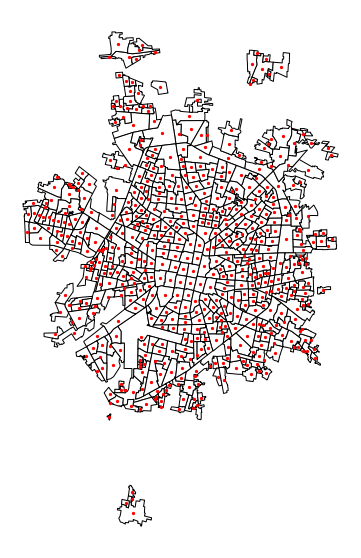

In [66]:
fig, ax = plt.subplots(figsize=(10, 10))
merida_kanasing_ageb.geometry.plot(ax=ax, color='white', edgecolor='black')
# Need to provide "zorder" to ensure the points are plotted above the polygons
merida_kanasing_ageb.centroid.plot(ax=ax, color='red', markersize=5, zorder=10)
#ax.set_title("Centroids of AGEBs", fontsize=20)
ax.set_axis_off()
plt.show()

# View the data from the nodes and edges of the road network from OSM (the projected representation)

In [76]:
nodes_proj.head()

,y,x,street_count,lon,lat,highway,geometry
osmid,,,,,,,
286974477,2.379984e+06,-9.964126e+06,4,-89.509268,20.900216,NaN,POINT (-9964126.091 2379984.358)
5443055966,2.379802e+06,-9.964163e+06,3,-89.509599,20.898686,NaN,POINT (-9964163.026 2379802.104)
2198242153,2.380420e+06,-9.964889e+06,3,-89.516119,20.903869,NaN,POINT (-9964888.729 2380419.666)
286974740,2.380557e+06,-9.966069e+06,3,-89.526717,20.905018,NaN,POINT (-9966068.560 2380556.620)
2198242162,2.380172e+06,-9.965677e+06,3,-89.523199,20.901791,NaN,POINT (-9965676.916 2380172.023)


In [78]:
edges_proj.head()

osmid  oneway      ref  \
u          v          key                                            
286974477  5443055966 0                  42683673    True  MEX 188   
           2198242153 0                 209633188   False      NaN   
5443055966 5443055948 0                  42683673    True  MEX 188   
           5443055955 0                 565071113    True      NaN   
2198242153 2198242137 0    [684178840, 209633186]   False      NaN   

                                highway maxspeed   length  \
u          v          key                                   
286974477  5443055966 0         primary       90  173.530   
           2198242153 0     residential      NaN  829.226   
5443055966 5443055948 0         primary       90  134.567   
           5443055955 0    primary_link      NaN   14.896   
2198242153 2198242137 0     residential      NaN  735.164   

                                                                    geometry  \
u          v          key                                                      
286974477  5443055966 0    LINESTRING (-9964126.091 2379984.358, -9964163...   
           2198242153 0    LINESTRING (-9964126.091 2379984.358, -9964147...   
5443055966 5443055948 0    LINESTRING (-9964163.026 2379802.104, -9964194...   
           5443055955 0    LINESTRING (-9964163.026 2379802.104, -9964158...   
2198242153 2198242137 0    LINESTRING (-9964888.729 2380419.666, -9964913...   

                          name lanes bridge junction tunnel width access  
u          v          key                                                 
286974477  5443055966 0    NaN   NaN    NaN      NaN    NaN   NaN    NaN  
           2198242153 0    NaN   NaN    NaN      NaN    NaN   NaN    NaN  
5443055966 5443055948 0    NaN   NaN    NaN      NaN    NaN   NaN    NaN  
           5443055955 0    NaN   NaN    NaN      NaN    NaN   NaN    NaN  
2198242153 2198242137 0    NaN   NaN    NaN      NaN    NaN   NaN    NaN

# Creating undirected simple graph representation

# Measures

#### Basic stats:

<ul>
    <li>n = number of nodes in the graph</li>
    <li>m = number of edges in the graph </li>
    <li>k_avg = average node degree of the graph </li>
    <li> intersection_count = number of intersections in graph, that is,
    nodes with >1 physical street connected to them </li>
    <li>streets_per_node_avg = how many physical streets (edges in the
    undirected representation of the graph) connect to each node (ie, intersection or dead-end) on average (mean) </li>
    <li>streets_per_node_counts = dict with keys of number of physical
    streets connecting to a node, and values of number of nodes with this count </li>
    <li>streets_per_node_proportion = dict, same as previous, but as a
    proportion of the total, rather than counts </li>
    <li>edge_length_total = sum of all edge lengths in graph, in meters </li>
    <li>edge_length_avg = mean edge length in the graph, in meters </li>
    <li>street_length_total = sum of all edges in the undirected
    representation of the graph </li>
    <li>street_length_avg = mean edge length in the undirected
    representation of the graph, in meters </li>
    <li>street_segments_count = number of edges in the undirected
    representation of the graph</li>
    <li>node_density_km = n divided by area in square kilometers</li>
    <li>intersection_density_km = intersection_count divided by area in
    square kilometers</li>
    <li>edge_density_km = edge_length_total divided by area in square
    kilometers</li>
    <li>street_density_km = street_length_total divided by area in square
    kilometers</li>
    <li>circuity_avg = edge_length_total divided by the sum of the great
    circle distances between the nodes of each edge</li>
    <li>self_loop_proportion = proportion of edges that have a single node
    as its endpoints (ie, the edge links nodes u and v, and u==v)</li>
    <li>clean_intersection_count = number of intersections in street
    network, merging complex ones into single points</li>
    <li>clean_intersection_density_km = clean_intersection_count divided
    by area in square kilometers</li>
</ul>

#### Extended stats:

<ul>
    <li>avg_neighbor_degree = Mean degree of nodes in the neighborhood of each node</li>
    <li>avg_neighbor_degree_avg = Mean of all average neighborhood degrees in network</li>
    <li>avg_weighted_neighbor_degree = Mean degree of nodes in the neighborhood of each node, weighted by edge length</li>
    <li>avg_weighted_neighbor_degree_avg = Mean of all weighted average neighborhood degrees in network</li>
    <li>degree_centrality = Fraction of nodes that each node is connected to</li>
    <li>degree_centrality_avg = Mean of all degree centralities in network</li>
    <li>clustering_coefficient = Extent to which node's neighborhood forms a complete graph</li>
    <li>clustering_coefficient_avg</li>
    <li>clustering_coefficient_weighted = Extent to which node's neighborhood forms a complete graph, weighted by edge length</li>
    <li>clustering_coefficient_weighted_avg = Mean of weighted clustering coefficients of all nodes in network</li>
    <li>pagerank = Ranking of nodes based on structure of incoming edges</li>
    <li>pagerank_max_node = Node with the maximum PageRank</li>
    <li>pagerank_max = Highest PageRank value of any node in the graph</li>
    <li>pagerank_min_node = Node with the minimum PageRank</li>
    <li>pagerank_min = Lowest PageRank value of any node in the graph</li>
    <li>node_connectivity = Minimum number of nodes that must be removed to disconnect network</li>
    <li>node_connectivity_avg = Expected number of nodes that must be removed to	disconnect randomly selected pair of non-adjacent nodes</li>
    <li>edge_connectivity = Minimum number of edges that must be removed to disconnect network</li>
    <li>eccentricity = For each node, the maximum distance from it to all other nodes, weighted by length</li>
    <li>diameter = Maximum eccentricity of any node in network</li>
    <li>radius = Minimum eccentricity of any node in network</li>
    <li>center = Set of all nodes whose eccentricity equals the radius</li>
    <li>periphery = Set of all nodes whose eccentricity equals the diameter</li>
    <li>closeness_centrality = For each node, the reciprocal of the sum of the distance from the node to all other nodes in the graph, weighted by length</li>
    <li>closeness_centrality_avg = Mean of all the closeness centralities of all the nodes in network</li>
    <li>betweenness_centrality = For each node, the fraction of all shortest paths that pass through the node</li>
    <li>betweenness_centrality_avg = Mean of all the betweenness centralities of all the nodes in network</li>
</ul>

In [40]:
# for each colonia polygon, find intersecting nodes then induce subgraph
j = 0
subgraphs_colonias = [] #vector for storing subgraphs
stats = [] #vector for storing stats from osmnx
vec = [] #vector for storing stats both basic and extended; only the values
for i in range(colonias_yucatan_merida_kanasin.size):
    j = j+1
    if j == 10: #only the first 10 colonia; just for testing
        break
        
    #polygon = colonias_yucatan_merida.iloc[i].geometry
    #colonia_name = colonias_yucatan_merida.iloc[i].SETT_NAME
    #mun_name = colonias_yucatan_merida.iloc[i].MUN_NAME
    #ob_id = colonias_yucatan_merida.iloc[i].OBJECTID

    
    try: 
        #try/except for handling empty graphs; 
        #if the graph is empty, NetworkX raises an error and stops the loop;
        #this code ignores the empty graphs in the except statement
        intersecting_nodes = nodes[nodes.intersects(polygon)].index
        G_sub = G.subgraph(intersecting_nodes)
        subgraphs_colonias.append(G_sub)
        stat = ox.basic_stats(G_sub, 
                              area=None, #the land area of this study site, in square meters. must be greater than 0. if None, will skip all density-based metrics.
                              clean_intersects=False, #if True, calculate consolidated intersections count (and density, if area is provided) via consolidate_intersections function
                              circuity_dist='gc') #‘gc’ or ‘euclidean’, how to calculate straight-line distances for circuity measurement; use former for lat-lng networks and latter for projected networks
        extended_stat = ox.extended_stats(G_sub, 
                                          connectivity=False, #if True, calculate node and edge connectivity
                                          anc=False, #if True, calculate average node connectivity
                                          ecc=True, #calculate shortest paths, eccentricity, and topological metrics that use eccentricity
                                          bc=True, #calculate node betweenness centrality
                                          cc=True) #calculate node closeness centrality
        for key, value in extended_stat.items():
            stat[key] = value #insert the extended stats values
        vec = [stat[elem] for elem in stat if isinstance(stat[elem], dict) == False] #add only the values except the dict type
        stats.append(vec)
        #print(ob_id + ", " + colonia_name + ", " + mun_name)
        #fig, ax = ox.plot_graph(G_sub)
    except:
        pass